In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

### Importing saved metrics JSON files

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist, or the JSON is
    not well-formed.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    try:
        with open(path, "r") as f:
            return json.load(f)
    except json.JSONDecodeError:
        print("Metrics JSON at %s is not well-formed" % path)

In [3]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func, max_epoch=None):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return True if the _first_ one is better. If `max_epoch` is provided, will only
    report everything up to this epoch (1-indexed).
    Returns the number of the run, the (one-indexed) number of the epoch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                if i == max_epoch:
                    break
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception as e:
            print(e)
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

### Profile models

In [4]:
def print_profile_losses(models_path, max_epoch=None):
    """
    Given the path to a condition containing many runs, prints out the best validation
    profile NLL losses for each run, and the set of profile NLL losses for training
    and validation over all epochs, as well as the validation prior loss. If given,
    only consider up to `max_epoch` epochs total; anything afterward would be ignored.
    """
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y,
        max_epoch
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)[:max_epoch]]))
    return all_vals

In [6]:
profile_models_path = "/users/amtseng/att_priors/models/trained_models/profile/"

In [114]:
noprior_prof_val_losses = print_profile_losses(os.path.join(profile_models_path, "BPNet"))

Best profile loss overall:
	Best run: 15
	Best epoch in run: 17
	Associated value: 142.88365456803515
Best epoch in each run:
	Run 1, epoch 16: 143.78
	Run 2, epoch 18: 143.75
	Run 3, epoch 16: 143.11
	Run 4, epoch 17: 143.62
	Run 5, epoch 17: 143.63
	Run 6, epoch 20: 143.90
	Run 7, epoch 20: 144.49
	Run 8, epoch 15: 143.00
	Run 9, epoch 19: 143.09
	Run 10, epoch 17: 143.42
	Run 11, epoch 19: 143.30
	Run 12, epoch 20: 144.45
	Run 13, epoch 14: 143.77
	Run 14, epoch 18: 144.14
	Run 15, epoch 17: 142.88
	Run 16, epoch 19: 144.74
	Run 17, epoch 12: 144.98
All validation profile and prior losses:
1
	142.80 138.22 136.16 135.02 134.36 133.95 133.61 133.34 133.12 132.95 132.81 132.72 132.61 132.51 132.47 132.39 132.32 132.30 132.28 132.19
	150.14 147.67 146.36 145.37 145.03 144.62 144.45 144.22 144.07 144.04 144.06 144.15 143.96 143.83 143.91 143.78 143.87 143.86 143.87 143.83
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0

In [116]:
prior_prof_val_losses = print_profile_losses(os.path.join(profile_models_path, "BPNet_prior"))

Best profile loss overall:
	Best run: 7
	Best epoch in run: 18
	Associated value: 143.4796766801314
Best epoch in each run:
	Run 2, epoch 16: 145.25
	Run 3, epoch 20: 143.98
	Run 4, epoch 19: 145.30
	Run 5, epoch 18: 144.63
	Run 6, epoch 18: 144.26
	Run 7, epoch 18: 143.48
	Run 8, epoch 20: 145.45
	Run 9, epoch 12: 145.41
All validation profile and prior losses:
2
	144.89 144.60 143.85 141.75 137.75 136.32 135.75 135.57 135.57 135.44 135.17 135.71 135.31 134.91 134.68 134.50 135.16
	155.17 155.10 153.42 149.85 147.48 146.54 146.71 146.47 146.19 146.29 146.10 146.78 145.89 145.52 145.36 145.25 146.13
	0.0363 0.0288 0.1057 0.0899 0.0631 0.0581 0.0575 0.0555 0.0609 0.1094 0.0746 0.0702 0.0648 0.0626 0.0642 0.0661 0.0826
3
	144.38 144.02 143.98 143.67 141.51 137.81 135.65 134.68 134.44 134.27 134.10 133.99 133.85 133.76 133.59 133.45 133.35 133.21 133.15 133.12
	154.51 154.42 154.48 153.22 151.05 147.30 146.01 145.62 144.90 144.75 145.20 144.83 144.51 144.42 144.39 144.33 144.63 144.12 144

Mean without priors: 1232.980928
Mean with priors: 1236.276370
One-sided t-test p: 0.438116


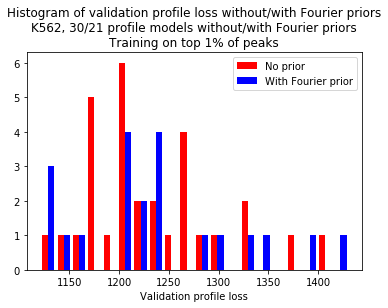

In [78]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_prof_val_losses.values())), np.array(list(prior_prof_val_losses.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With Fourier prior"], color=["red", "blue"])
title = "Histogram of validation profile loss without/with Fourier priors"
title += "\nK562, %d/%d profile models without/with Fourier priors" % (len(noprior_prof_val_losses), len(prior_prof_val_losses))
title += "\nTraining on top 1% of peaks"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

np_vals, p_vals = np.array(list(noprior_prof_val_losses.values())), np.array(list(prior_prof_val_losses.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print("Mean without priors: %f" % np.mean(np_vals))
print("Mean with priors: %f" % np.mean(p_vals))
print("One-sided t-test p: %f" % (p / 2))

### Binary models

In [79]:
def print_binary_losses(models_path, max_epoch=None):
    """
    Given the path to a condition containing many runs, prints out the best validation
    losses for each run, and the set of losses for training and validation over all
    epochs, as well as the validation prior loss. If given, only consider up to
    `max_epoch` epochs total; anything afterward would be ignored.
    """
    print("Best validation loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y,
        max_epoch
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.3f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["train_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)[:max_epoch]]))
    return all_vals

In [80]:
binary_models_path = "/users/amtseng/att_priors/models/trained_models/binary/"

In [128]:
noprior_bin_val_losses = print_binary_losses(os.path.join(binary_models_path, "BPNet"))

Best validation loss overall:
	Best run: 22
	Best epoch in run: 1
	Associated value: 0.3481439769790884
Best epoch in each run:
	Run 1, epoch 1:  0.357
	Run 2, epoch 1:  0.361
	Run 3, epoch 1:  0.364
	Run 4, epoch 1:  0.365
	Run 5, epoch 1:  0.360
	Run 6, epoch 1:  0.353
	Run 7, epoch 1:  0.356
	Run 8, epoch 1:  0.354
	Run 9, epoch 1:  0.355
	Run 10, epoch 1:  0.353
	Run 11, epoch 1:  0.365
	Run 12, epoch 1:  0.358
	Run 13, epoch 1:  0.355
	Run 14, epoch 1:  0.365
	Run 15, epoch 1:  0.355
	Run 16, epoch 2:  0.364
	Run 17, epoch 1:  0.353
	Run 18, epoch 1:  0.354
	Run 19, epoch 1:  0.355
	Run 20, epoch 2:  0.361
	Run 21, epoch 1:  0.355
	Run 22, epoch 1:  0.348
	Run 23, epoch 1:  0.366
	Run 24, epoch 1:  0.352
	Run 25, epoch 1:  0.355
	Run 26, epoch 1:  0.352
	Run 27, epoch 2:  0.355
	Run 28, epoch 1:  0.355
	Run 29, epoch 2:  0.357
	Run 30, epoch 1:  0.355
All validation profile and prior losses:
1
	 0.375  0.304  0.272  0.245  0.226
	 0.357  0.365  0.389  0.425  0.464
	 0.000  0.000  

In [129]:
prior_bin_val_losses = print_binary_losses(os.path.join(binary_models_path, "BPNet_prior"))

Best validation loss overall:
	Best run: 16
	Best epoch in run: 11
	Associated value: 0.34586371640887176
Best epoch in each run:
	Run 1, epoch 20:  0.355
	Run 2, epoch 10:  0.349
	Run 3, epoch 5:  0.349
	Run 4, epoch 17:  0.352
	Run 5, epoch 16:  0.354
	Run 6, epoch 9:  0.349
	Run 7, epoch 14:  0.352
	Run 8, epoch 11:  0.350
	Run 9, epoch 5:  0.368
	Run 10, epoch 20:  0.361
	Run 11, epoch 9:  0.372
	Run 12, epoch 15:  0.349
	Run 13, epoch 10:  0.365
	Run 14, epoch 2:  0.377
	Run 15, epoch 16:  0.350
	Run 16, epoch 11:  0.346
	Run 17, epoch 7:  0.395
All validation profile and prior losses:
1
	 0.527  0.433  0.395  0.443  0.395  0.360  0.360  0.362  0.377  0.357  0.353  0.366  0.371  0.347  0.350  0.341  0.330  0.342  0.329  0.316
	 0.526  0.409  0.493  0.413  0.386  0.373  0.370  0.389  0.382  0.369  0.368  0.394  0.372  0.364  0.369  0.363  0.359  0.370  0.373  0.355
	 0.080  0.053  0.079  0.057  0.046  0.050  0.053  0.074  0.064  0.058  0.056  0.083  0.056  0.056  0.065  0.053  0.05

Mean without priors: 0.357163
Mean with priors: 0.358436
One-sided t-test p: 0.318830


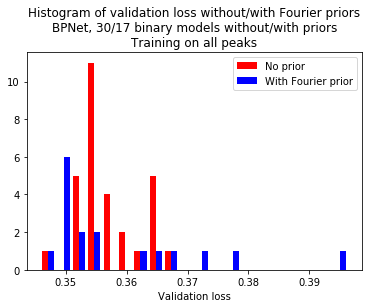

In [101]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_bin_val_losses.values())), np.array(list(prior_bin_val_losses.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With Fourier prior"], color=["red", "blue"])
title = "Histogram of validation loss without/with Fourier priors"
title += "\nBPNet, %d/%d binary models without/with priors" % (len(noprior_bin_val_losses), len(prior_bin_val_losses))
title += "\nTraining on all peaks"
plt.title(title)
plt.xlabel("Validation loss")
plt.legend()

np_vals, p_vals = np.array(list(noprior_bin_val_losses.values())), np.array(list(prior_bin_val_losses.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print("Mean without priors: %f" % np.mean(np_vals))
print("Mean with priors: %f" % np.mean(p_vals))
print("One-sided t-test p: %f" % (p / 2))